# CTM MILP Model Running Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time

from ctmmodels.const import *
from ctmmodels.delaythroughput import DelayThroughputSimplex as Model

In [2]:
IMAGE_PATH = 'graphs/'
DF_PATH = 'dataframes/'

**Notes on the models and parameters being used:**

* 2 separate formulations were made: 1 dealing with individual movements in the intersection, and another dealing with phases in the stoplight. The latter has 33% less binary variables, and thus performed better in basic tests.

* Saturation flow rate will be set to 600 vph instead of the 450 vph in the parent paper; this is so as to test both under and over saturated conditions.

* Traffic will be distributed evenly between the 3 possible turns (left, through, and right). This is based on previous tests where left was getting essentially 0 green time.

* Time range will be set to 60 seconds, or 30 time steps at 2 seconds per time step. Preliminary experiments show that 50 is the optimal cycle time for both delay and throughput (at demands ranging from 450 to 900 vph). *However*, previous tests on this model showed that no time was allotted to left turns when the cycle time was too small.

In [3]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

# Varying parameters: demand, use_flow_weight, flow_weight, alpha

In [4]:
def run_model(demand, alpha=1, beta=0, gamma=0, log_output=True):
    model = Model(
        demand=demand,
        alpha=alpha,
        beta=beta,
        gamma=gamma,
        **parameters
    )
    model.generate()
    runtime = model.solve(log_output=log_output)
    dfx, dfy, dfg = model.return_solution()
    dfparams = model.return_parameters()
    obj_values = model.return_objective_value()
    return dfx, dfy, dfg, dfparams, obj_values, runtime

## Intersection Cell Network

![title](img/4leg-intersection.png)

## Setting the path of cells to check

In [5]:
_approach = 0

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

## Comparing cell volumes

In [6]:
def plot_volume(dfx, cell_path, title, headless=True, filename='volume.png'):
    dfx_approach = pd.concat([
        dfx[dfx.cell == c].sort_values(by='timestep')
        for c in cell_path
    ]).pivot(index='timestep', columns='cell', values='volume')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))
    
    sns.lineplot(data=dfx_approach, ax=axs[0])
    sns.lineplot(data=dfx_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Volume of cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous volume')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Volume of cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative volume')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing flows

In [7]:
def plot_flow(dfy, cell_path, title, headless=True, filename='flow.png'):
    dfy_approach = pd.concat([
        dfy[dfy.cell_from == c].groupby(['cell_from', 'timestep']).agg({'flow': 'sum'}).sort_values(by='timestep')
        for c in cell_path
    ]).reset_index().pivot(index='timestep', columns='cell_from', values='flow')
    
    fig, axs = plt.subplots(1,2, figsize=(20,10))

    sns.lineplot(data=dfy_approach, ax=axs[0])
    sns.lineplot(data=dfy_approach.cumsum(), ax=axs[1])

    axs[0].set_title('Flow from cells')
    axs[0].set_xlabel('Timesteps')
    axs[0].set_ylabel('Instantaneous flow')
    axs[0].set_xticks(time_ticks, minor=True)

    axs[1].set_title('Flow from cells (cumulative)')
    axs[1].set_xlabel('Timesteps')
    axs[1].set_ylabel('Cumulative flow')
    axs[1].set_xticks(time_ticks, minor=True)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Comparing specific green time

In [8]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Generating graphs for each model case

In [9]:
def generate_graphs(dfx, dfy, dfg, capacity, max_flow, demand, alpha, flow_weight, folder=''):
    cell_paths = movement_paths(_approach)
    
    for ndx, cellpath in enumerate(cell_paths):
        if dfx is not None:
            plot_volume(dfx,
                        cellpath,
                        '''Volume in cells at {} vph and {}% delay weight ({} turn)
                        (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                            .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                        filename=folder+'volumes/{}vph_{}alpha_{}flow_volume_{}.png'
                            .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
        
        if dfy is not None:
            plot_flow(dfy,
                      cellpath,
                      '''Flow from cells at {} vph and {}% delay weight ({} turn)
                      (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                          .format(demand, alpha*100, _approach_terms[ndx], capacity, max_flow, flow_weight),
                      filename=folder+'flows/{}vph_{}alpha_{}flow_flow_{}.png'
                          .format(demand, alpha, flow_weight, _approach_terms[ndx].lower()))
    
    if dfg is not None:
        plot_greentime(dfg,
                       '''Green times at {} vph and {}% delay weight
                       (Cap: {:.2f}, Max Flow: {}, Flow Weight: {})'''
                           .format(demand, alpha*100, capacity, max_flow, flow_weight),
                       filename=folder+'greentimes/{}vph_{}alpha_{}flow_greetime.png'
                           .format(demand, alpha, flow_weight))

In [10]:
def plot_obj_values(obj_values, title, xaxis, xlabel, headless=True, filename='obj.png'):
    fig, axs = plt.subplots(1,2,figsize=(20,10))

    axs[0].plot(xaxis, [x[0] for x in obj_values])
    axs[0].set_title("Computed total delay")
    axs[0].set_ylabel("Total vehicle delay (timesteps)")
    axs[0].set_xlabel(xlabel)

    axs[1].plot(xaxis, [x[1] for x in obj_values])
    axs[1].set_title("Computed total throughput")
    axs[1].set_ylabel("Total vehicle throughput (veh)")
    axs[1].set_xlabel(xlabel)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

## Saving dataframes

In [11]:
def save_df(df, filename):
    df.to_pickle(DF_PATH + filename + ".pkl")

## 1. Plotting delay and throughput on the simplex

In [12]:
def generate_simplex(steps=10):
    simplex = [(a,b,steps-(a+b)) for a in range(steps+1) for b in range(steps - a + 1)]
    normalized = []
    for point in simplex:
        normalized.append((float(point[0]) / steps, float(point[1]) / steps, float(point[2]) / steps))
    return normalized

In [13]:
def run_on_simplex(demand=900, simplex_slice=[], log_output=False, folder='triple_simplex/', batchrun=1):
    _df_tuples = []
    
    for p in simplex_slice:
        a, b, c = p
        dfx, dfy, dfg, dfparams, obj_values, runtime = run_model(demand=demand, alpha=a, beta=b, gamma=c, log_output=log_output)
        _df_tuples.append((demand, runtime, obj_values[0], obj_values[1], obj_values[2], a, b, c))
        save_df(dfx, "{}volumes/volumes_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        save_df(dfy, "{}flows/flows_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        save_df(dfg, "{}greentimes/greentimes_d{}_a{}_b{}_c{}".format(folder, demand, a, b, c))
        print("\n~~~\nDone with demand {}, point ({}, {}, {})!\n~~~\n".format(demand, a, b, c))
    
    df = pd.DataFrame(data=_df_tuples,columns=['demand', 'runtime', 'delay', 'throughput', 'objective_value', 'alpha', 'beta', 'gamma'])
    save_df(df, "{}results_simplex_d{}_{}".format(folder, demand, batchrun))
    return df

In [14]:
_grid = generate_simplex()
_demands = [x for x in range(450,1801,50)]
_batchsize = 4

In [15]:
450+900

1350

In [16]:
#print("~~~~ Demand = {} ~~~~".format(x))
run_on_simplex(1350, simplex_slice=_grid, batchrun=6)

Solving...
Done!
Time elapsed: 0.529932975769

~~~
Done with demand 1350, point (0.0, 0.0, 1.0)!
~~~

Solving...
Done!
Time elapsed: 0.274410963058

~~~
Done with demand 1350, point (0.0, 0.1, 0.9)!
~~~

Solving...
Done!
Time elapsed: 0.610217094421

~~~
Done with demand 1350, point (0.0, 0.2, 0.8)!
~~~

Solving...
Done!
Time elapsed: 0.92948102951

~~~
Done with demand 1350, point (0.0, 0.3, 0.7)!
~~~

Solving...
Done!
Time elapsed: 0.743527173996

~~~
Done with demand 1350, point (0.0, 0.4, 0.6)!
~~~

Solving...
Done!
Time elapsed: 0.946290969849

~~~
Done with demand 1350, point (0.0, 0.5, 0.5)!
~~~

Solving...
Done!
Time elapsed: 0.387392997742

~~~
Done with demand 1350, point (0.0, 0.6, 0.4)!
~~~

Solving...
Done!
Time elapsed: 0.503174066544

~~~
Done with demand 1350, point (0.0, 0.7, 0.3)!
~~~

Solving...
Done!
Time elapsed: 0.611775159836

~~~
Done with demand 1350, point (0.0, 0.8, 0.2)!
~~~

Solving...
Done!
Time elapsed: 0.755532979965

~~~
Done with demand 1350, point (0.

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,1350,0.529933,4225.898734,41.556962,-3527.426160,0.0,0.0,1.0
1,1350,0.274411,4262.854430,43.987342,-3191.137143,0.0,0.1,0.9
2,1350,0.610217,4159.822785,44.556962,-2855.274262,0.0,0.2,0.8
3,1350,0.929481,4107.487342,44.556962,-2519.198312,0.0,0.3,0.7
4,1350,0.743527,4164.215190,44.556962,-2183.122363,0.0,0.4,0.6
5,1350,0.946291,4142.822785,44.556962,-1847.046414,0.0,0.5,0.5
6,1350,0.387393,4116.651899,44.556962,-1510.970464,0.0,0.6,0.4
7,1350,0.503174,4147.067511,44.556962,-1174.894515,0.0,0.7,0.3
8,1350,0.611775,4142.753165,44.556962,-838.818565,0.0,0.8,0.2
9,1350,0.755533,4156.607595,44.556962,-502.742616,0.0,0.9,0.1


In [19]:
df = pd.read_pickle(DF_PATH + "triple_simplex/results_simplex_d900_2.pkl")

In [20]:
df

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,900,1.023374,2466.544304,42.556962,-3080.590717,0.0,0.0,1.0
1,900,0.985121,2412.025316,44.556962,-2789.198312,0.0,0.1,0.9
2,900,1.438595,2403.544304,44.556962,-2497.805907,0.0,0.2,0.8
3,900,0.467626,2427.166667,44.556962,-2206.413502,0.0,0.3,0.7
4,900,0.663082,2432.265823,44.556962,-1915.021097,0.0,0.4,0.6
5,900,0.862824,2451.291139,44.556962,-1623.628692,0.0,0.5,0.5
6,900,0.591435,2416.006329,44.556962,-1332.236287,0.0,0.6,0.4
7,900,0.927105,2475.251055,44.556962,-1040.843882,0.0,0.7,0.3
8,900,0.819589,2460.672996,44.556962,-749.451477,0.0,0.8,0.2
9,900,0.551814,2465.626582,44.556962,-458.059072,0.0,0.9,0.1


In [21]:
import ternary

In [32]:
df_nparr = df.values
delay_dict = {}
thru_dict = {}
runtime_dict = {}

for row in df_nparr:
    runtime_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[1]
    delay_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[2]
    thru_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[3]


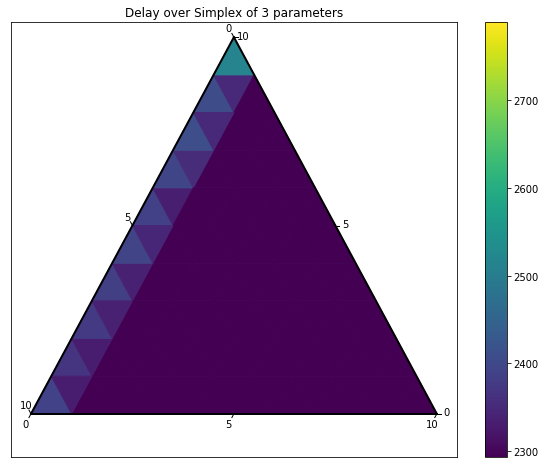

In [34]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(delay_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Delay over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

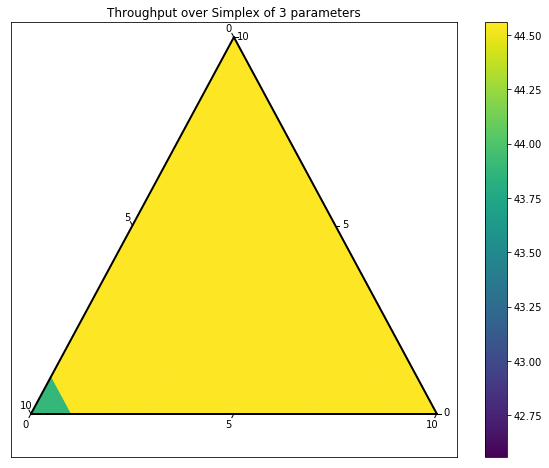

In [35]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(thru_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Throughput over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

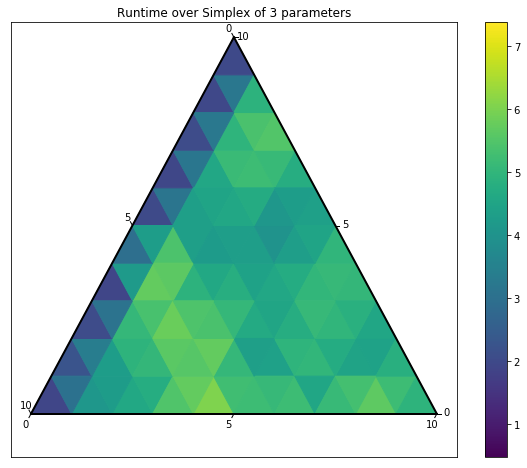

In [37]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(runtime_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Runtime over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()